In [ ]:
!wget https://www.machinehack.com/wp-content/uploads/2020/06/ODI_Participants_Data.zip

--2020-06-21 10:27:33--  https://www.machinehack.com/wp-content/uploads/2020/06/ODI_Participants_Data.zip
Resolving www.machinehack.com (www.machinehack.com)... 107.180.71.20
Connecting to www.machinehack.com (www.machinehack.com)|107.180.71.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75917 (74K) [application/zip]
Saving to: ‘ODI_Participants_Data.zip.1’

ODI_Participants_Da 100%[===================>]  74.14K   327KB/s    in 0.2s    

2020-06-21 10:27:34 (327 KB/s) - ‘ODI_Participants_Data.zip.1’ saved [75917/75917]



In [ ]:
!unzip ODI_Participants_Data.zip

Archive:  ODI_Participants_Data.zip
replace ODI_Participants_Data/Test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: ODI_Participants_Data/Test.csv  
  inflating: __MACOSX/ODI_Participants_Data/._Test.csv  
  inflating: ODI_Participants_Data/Sample_submission.xlsx  
  inflating: __MACOSX/ODI_Participants_Data/._Sample_submission.xlsx  
  inflating: ODI_Participants_Data/Train.csv  
  inflating: __MACOSX/ODI_Participants_Data/._Train.csv  


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
train = pd.read_csv('ODI_Participants_Data/Train.csv')
test = pd.read_csv('ODI_Participants_Data/Test.csv')
sub = pd.read_excel('ODI_Participants_Data/Sample_submission.xlsx')

In [ ]:
train.head(5)

,Team1,Team2,Stadium,HostCountry,Team1_Venue,Team2_Venue,Team1_Innings,Team2_Innings,MonthOfMatch,MatchWinner
0,5,4,37,4,Home,Away,Second,First,Dec,4
1,1,14,84,7,Neutral,Neutral,First,Second,Sep,1
2,9,15,47,9,Home,Away,First,Second,Feb,9
3,7,2,102,6,Home,Away,First,Second,Aug,2
4,6,8,46,5,Home,Away,First,Second,Aug,6


In [ ]:
test.tail(5)

,Team1,Team2,Stadium,HostCountry,Team1_Venue,Team2_Venue,Team1_Innings,Team2_Innings,MonthOfMatch
1070,15,5,64,16,Home,Away,First,Second,Jun
1071,1,12,95,0,Home,Away,First,Second,Feb
1072,5,10,43,1,Neutral,Neutral,First,Second,Mar
1073,10,13,111,0,Neutral,Neutral,Second,First,Mar
1074,5,9,111,0,Neutral,Neutral,First,Second,Dec


In [ ]:
train.isnull().sum(),test.isnull().sum(),train.shape,test.shape,train.dtypes

(Team1            0
 Team2            0
 Stadium          0
 HostCountry      0
 Team1_Venue      0
 Team2_Venue      0
 Team1_Innings    0
 Team2_Innings    0
 MonthOfMatch     0
 MatchWinner      0
 dtype: int64, Team1            0
 Team2            0
 Stadium          0
 HostCountry      0
 Team1_Venue      0
 Team2_Venue      0
 Team1_Innings    0
 Team2_Innings    0
 MonthOfMatch     0
 dtype: int64, (2508, 10), (1075, 9), Team1             int64
 Team2             int64
 Stadium           int64
 HostCountry       int64
 Team1_Venue      object
 Team2_Venue      object
 Team1_Innings    object
 Team2_Innings    object
 MonthOfMatch     object
 MatchWinner       int64
 dtype: object)

In [ ]:
df=train.append(test,ignore_index=True)

In [ ]:
df = pd.get_dummies(df, columns=['Team1_Venue','Team2_Venue','Team1_Innings','Team2_Innings','MonthOfMatch','Team1','Team2','HostCountry','Stadium'])

In [ ]:
df.tail(2)

,MatchWinner,Team1_Venue_Away,Team1_Venue_Home,Team1_Venue_Neutral,Team2_Venue_Away,Team2_Venue_Home,Team2_Venue_Neutral,Team1_Innings_First,Team1_Innings_Second,Team2_Innings_First,Team2_Innings_Second,MonthOfMatch_Apr,MonthOfMatch_Aug,MonthOfMatch_Dec,MonthOfMatch_Feb,MonthOfMatch_Jan,MonthOfMatch_Jul,MonthOfMatch_Jun,MonthOfMatch_Mar,MonthOfMatch_May,MonthOfMatch_Nov,MonthOfMatch_Oct,MonthOfMatch_Sep,Team1_0,Team1_1,Team1_2,Team1_3,Team1_4,Team1_5,Team1_6,Team1_7,Team1_8,Team1_9,Team1_10,Team1_11,Team1_12,Team1_13,Team1_14,Team1_15,Team2_0,...,Stadium_112,Stadium_113,Stadium_114,Stadium_115,Stadium_116,Stadium_117,Stadium_118,Stadium_119,Stadium_120,Stadium_121,Stadium_122,Stadium_123,Stadium_124,Stadium_125,Stadium_126,Stadium_127,Stadium_128,Stadium_129,Stadium_130,Stadium_131,Stadium_132,Stadium_133,Stadium_134,Stadium_135,Stadium_136,Stadium_137,Stadium_138,Stadium_139,Stadium_140,Stadium_141,Stadium_142,Stadium_143,Stadium_144,Stadium_145,Stadium_146,Stadium_147,Stadium_148,Stadium_149,Stadium_150,Stadium_151
3581,NaN,0,0,1,0,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3582,NaN,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
train = df[df['MatchWinner'].isnull()==False]
test = df[df['MatchWinner'].isnull()==True]

In [ ]:
del test['MatchWinner']

In [ ]:
train.head(2)

,MatchWinner,Team1_Venue_Away,Team1_Venue_Home,Team1_Venue_Neutral,Team2_Venue_Away,Team2_Venue_Home,Team2_Venue_Neutral,Team1_Innings_First,Team1_Innings_Second,Team2_Innings_First,Team2_Innings_Second,MonthOfMatch_Apr,MonthOfMatch_Aug,MonthOfMatch_Dec,MonthOfMatch_Feb,MonthOfMatch_Jan,MonthOfMatch_Jul,MonthOfMatch_Jun,MonthOfMatch_Mar,MonthOfMatch_May,MonthOfMatch_Nov,MonthOfMatch_Oct,MonthOfMatch_Sep,Team1_0,Team1_1,Team1_2,Team1_3,Team1_4,Team1_5,Team1_6,Team1_7,Team1_8,Team1_9,Team1_10,Team1_11,Team1_12,Team1_13,Team1_14,Team1_15,Team2_0,...,Stadium_112,Stadium_113,Stadium_114,Stadium_115,Stadium_116,Stadium_117,Stadium_118,Stadium_119,Stadium_120,Stadium_121,Stadium_122,Stadium_123,Stadium_124,Stadium_125,Stadium_126,Stadium_127,Stadium_128,Stadium_129,Stadium_130,Stadium_131,Stadium_132,Stadium_133,Stadium_134,Stadium_135,Stadium_136,Stadium_137,Stadium_138,Stadium_139,Stadium_140,Stadium_141,Stadium_142,Stadium_143,Stadium_144,Stadium_145,Stadium_146,Stadium_147,Stadium_148,Stadium_149,Stadium_150,Stadium_151
0,4.0,0,1,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
test.head(2)

,Team1_Venue_Away,Team1_Venue_Home,Team1_Venue_Neutral,Team2_Venue_Away,Team2_Venue_Home,Team2_Venue_Neutral,Team1_Innings_First,Team1_Innings_Second,Team2_Innings_First,Team2_Innings_Second,MonthOfMatch_Apr,MonthOfMatch_Aug,MonthOfMatch_Dec,MonthOfMatch_Feb,MonthOfMatch_Jan,MonthOfMatch_Jul,MonthOfMatch_Jun,MonthOfMatch_Mar,MonthOfMatch_May,MonthOfMatch_Nov,MonthOfMatch_Oct,MonthOfMatch_Sep,Team1_0,Team1_1,Team1_2,Team1_3,Team1_4,Team1_5,Team1_6,Team1_7,Team1_8,Team1_9,Team1_10,Team1_11,Team1_12,Team1_13,Team1_14,Team1_15,Team2_0,Team2_1,...,Stadium_112,Stadium_113,Stadium_114,Stadium_115,Stadium_116,Stadium_117,Stadium_118,Stadium_119,Stadium_120,Stadium_121,Stadium_122,Stadium_123,Stadium_124,Stadium_125,Stadium_126,Stadium_127,Stadium_128,Stadium_129,Stadium_130,Stadium_131,Stadium_132,Stadium_133,Stadium_134,Stadium_135,Stadium_136,Stadium_137,Stadium_138,Stadium_139,Stadium_140,Stadium_141,Stadium_142,Stadium_143,Stadium_144,Stadium_145,Stadium_146,Stadium_147,Stadium_148,Stadium_149,Stadium_150,Stadium_151
2508,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2509,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
#Team1_Venue_Away
# Team2_Venue_Home

In [ ]:
train_df=train
test_df=test

In [ ]:
X = train_df.drop(labels=['MatchWinner'], axis=1)
y = train_df['MatchWinner'].values

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [ ]:
X_train.shape, y_train.shape, X_cv.shape, y_cv.shape

((1881, 223), (1881,), (627, 223), (627,))

In [ ]:
from sklearn.metrics import log_loss

In [ ]:

import lightgbm as lgb
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_cv, label=y_cv)

param = {'objective': 'multiclass',
         'num_class': 16,
         'boosting': 'gbdt',  
         'metric': 'multi_logloss',
         'learning_rate': 0.01, 
         'num_iterations': 1000,
         'num_leaves': 101,
         'max_depth': -1,
         'min_data_in_leaf': 15,
         'bagging_fraction':0.9,
         'bagging_freq': 1,
         'feature_fraction': 0.9,
         'lambda_l2': 0.9,
         'min_data_per_group': 75,
         'max_bin': 255,
         'is_unbalance':True
         }

clf = lgb.train(params=param, 
                early_stopping_rounds=200,
                verbose_eval=100,
                train_set=train_data,
                valid_sets=[test_data])

y_pred = clf.predict(X_cv)

Training until validation scores don't improve for 200 rounds.
[100]	valid_0's multi_logloss: 1.2902
[200]	valid_0's multi_logloss: 0.956042
[300]	valid_0's multi_logloss: 0.810506
[400]	valid_0's multi_logloss: 0.738237
[500]	valid_0's multi_logloss: 0.703362
[600]	valid_0's multi_logloss: 0.689351
[700]	valid_0's multi_logloss: 0.689189
[800]	valid_0's multi_logloss: 0.696647
Early stopping, best iteration is:
[644]	valid_0's multi_logloss: 0.687359


In [ ]:
log_loss(y_cv, y_pred)

0.6873585183221682

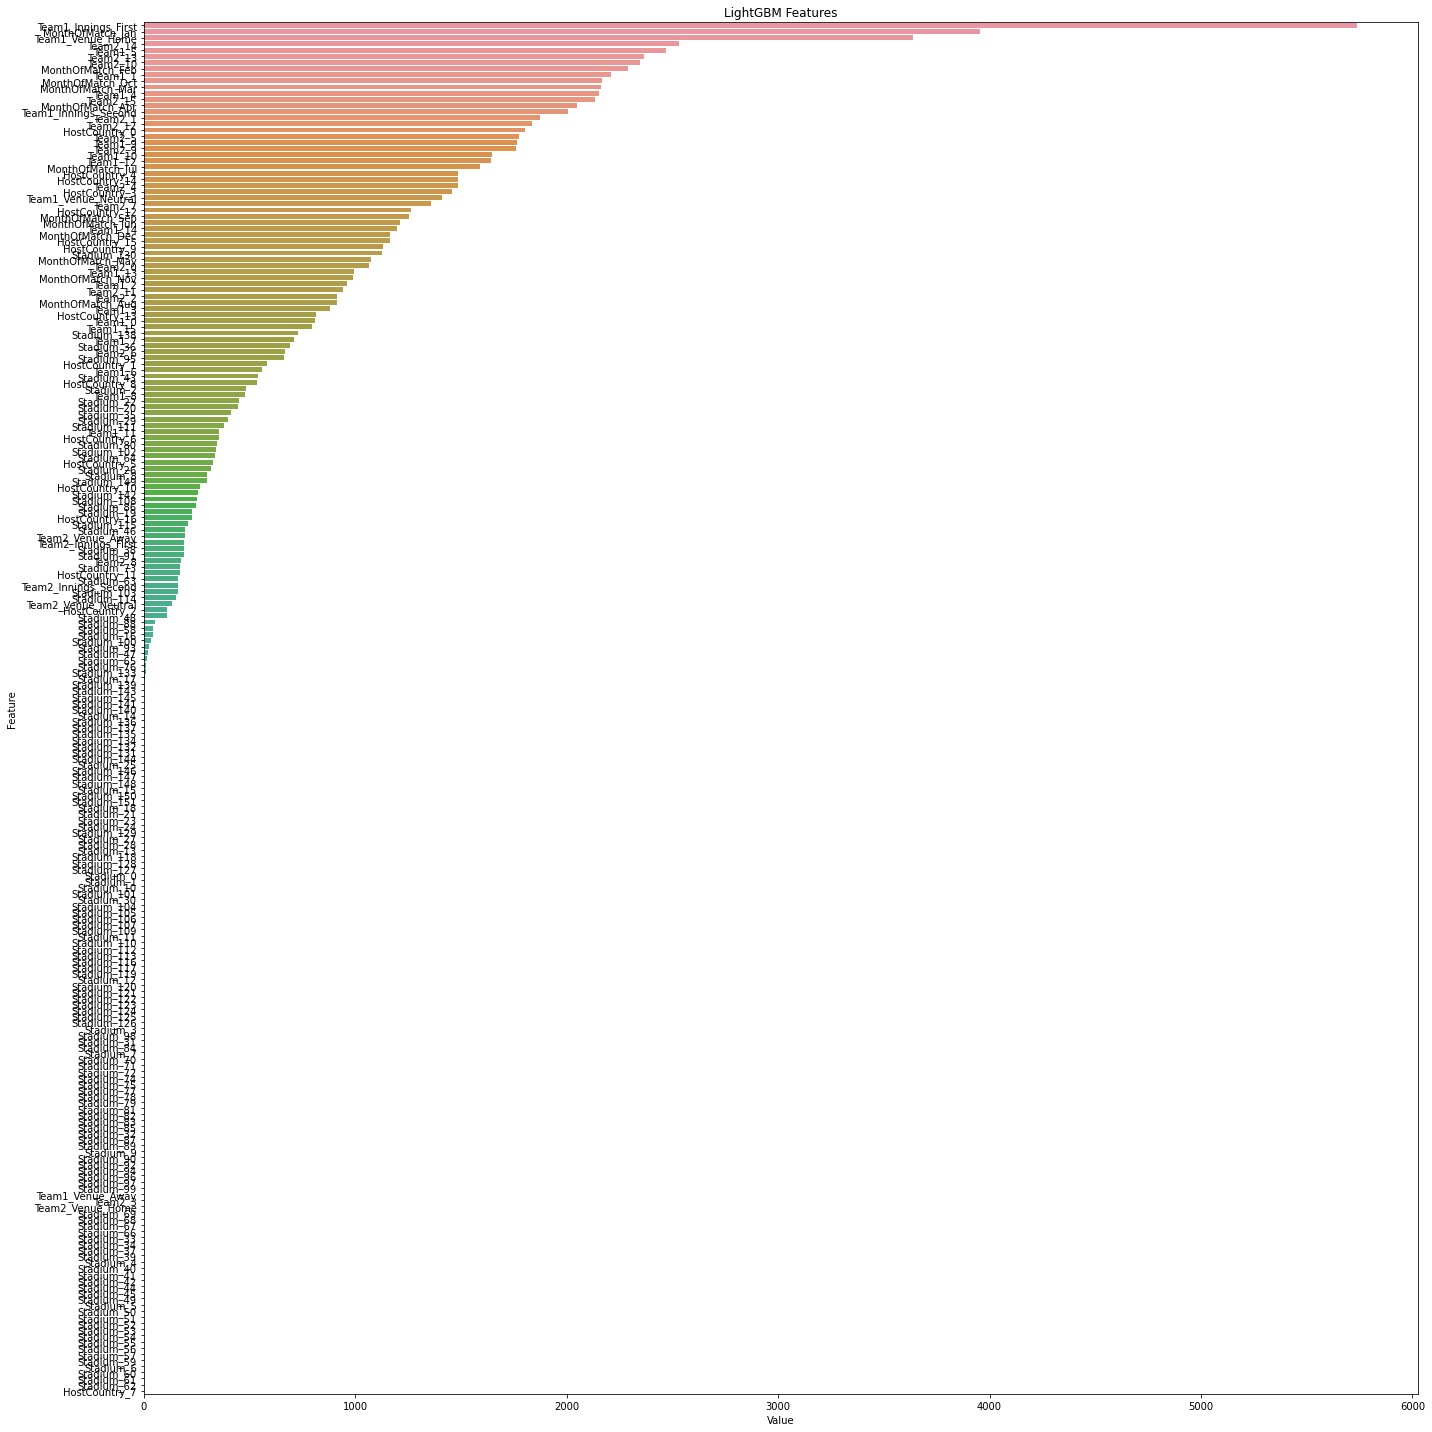

In [ ]:
import seaborn as sns
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importance(), X.columns), reverse=True)[:], columns=['Value','Feature'])
plt.figure(figsize=(20,20))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

In [ ]:
feature_imp.loc[feature_imp.Value >= 0].sort_values(by=['Value'], ascending = False)

,Value,Feature
0,5738,Team1_Innings_First
1,3954,MonthOfMatch_Jan
2,3637,Team1_Venue_Home
3,2529,Team2_14
4,2470,Team1_5
...,...,...
141,0,Stadium_6
140,0,Stadium_60
139,0,Stadium_61
138,0,Stadium_62


In [ ]:
Xtest = test_df

In [ ]:

from sklearn.model_selection import KFold, StratifiedKFold

errlgb = []
y_pred_totlgb = []

fold = StratifiedKFold(n_splits=6, shuffle=True, random_state=123456789)

for train_index, test_index in fold.split(X, y):
    
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test)
    
    clf = lgb.train(params=param, 
                     early_stopping_rounds=200,
                     verbose_eval=100,
                     train_set=train_data,
                     valid_sets=[test_data])

    y_pred = clf.predict(X_test)
    print("Log Loss: ", (log_loss(y_test, y_pred)))
    
    errlgb.append(log_loss(y_test, y_pred))
    p = clf.predict(Xtest)
    y_pred_totlgb.append(p)

Training until validation scores don't improve for 200 rounds.
[100]	valid_0's multi_logloss: 1.26256
[200]	valid_0's multi_logloss: 0.924229
[300]	valid_0's multi_logloss: 0.778882
[400]	valid_0's multi_logloss: 0.710139
[500]	valid_0's multi_logloss: 0.675303
[600]	valid_0's multi_logloss: 0.660132
[700]	valid_0's multi_logloss: 0.657034
[800]	valid_0's multi_logloss: 0.661963
Early stopping, best iteration is:
[658]	valid_0's multi_logloss: 0.656893
Log Loss:  0.6568925298753685
Training until validation scores don't improve for 200 rounds.
[100]	valid_0's multi_logloss: 1.30059
[200]	valid_0's multi_logloss: 0.976589
[300]	valid_0's multi_logloss: 0.835429
[400]	valid_0's multi_logloss: 0.768535
[500]	valid_0's multi_logloss: 0.736874
[600]	valid_0's multi_logloss: 0.725199
[700]	valid_0's multi_logloss: 0.728694
[800]	valid_0's multi_logloss: 0.739107
Early stopping, best iteration is:
[617]	valid_0's multi_logloss: 0.724531
Log Loss:  0.7245307604586604
Training until validation 

In [ ]:
np.mean(errlgb,0)

0.6928469771877691

In [ ]:
y_pred = np.mean(y_pred_totlgb,0)

In [ ]:
submission = pd.DataFrame(data=y_pred, columns=sub.columns)
submission.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.000591,0.004164,0.502802,0.000217,0.469585,0.003860,0.000414,0.000894,0.000247,0.002820,0.003636,0.000284,0.003074,0.002962,0.002978,0.001471
1,0.000494,0.679488,0.001360,0.000191,0.003685,0.003253,0.000579,0.000354,0.000289,0.002608,0.003180,0.000258,0.002708,0.002492,0.297898,0.001163
2,0.001390,0.003125,0.000665,0.000274,0.002681,0.003024,0.000600,0.000323,0.000219,0.231169,0.748559,0.000247,0.002250,0.002178,0.002143,0.001152
3,0.000580,0.003955,0.000924,0.000212,0.003118,0.003846,0.000495,0.000356,0.000258,0.427108,0.548213,0.000303,0.002803,0.003069,0.003144,0.001616
4,0.001606,0.006035,0.001439,0.001590,0.004266,0.814036,0.000727,0.000739,0.000445,0.004930,0.008084,0.000632,0.005789,0.006982,0.004956,0.137744


In [ ]:
submission.to_excel('blue.xlsx', index=False)

In [ ]:
from google.colab import files
files.download('blue.xlsx')

# r1

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import log_loss
from tqdm import tqdm_notebook
from sklearn.utils import shuffle

In [ ]:
TARGET_COL ='MatchWinner'
train, test = df.iloc[:train.shape[0]], df.iloc[train.shape[0]:]
test.reset_index(drop=True, inplace=True)
target = train[TARGET_COL]
features = [c for c in train.columns if c not in [TARGET_COL]]

In [ ]:
X_trn, X_val, y_trn, y_val = train_test_split(train[features], target, test_size=0.20, stratify=target, random_state=42)
X_test = test[features]

In [ ]:
clf = LGBMClassifier(learning_rate=0.01, n_estimators=1000,num_leaves=69)
_ = clf.fit(X_trn, y_trn, eval_set=[(X_trn, y_trn), (X_val, y_val)], verbose=100, early_stopping_rounds=100)
predictions_val_lgb = clf.predict_proba(X_val)
print(f"Log loss for Model 1 is: {log_loss(y_val, predictions_val_lgb)}")

Training until validation scores don't improve for 100 rounds.
[100]	training's multi_logloss: 1.19643	valid_1's multi_logloss: 1.26034
[200]	training's multi_logloss: 0.850449	valid_1's multi_logloss: 0.940778
[300]	training's multi_logloss: 0.690496	valid_1's multi_logloss: 0.804371
[400]	training's multi_logloss: 0.59963	valid_1's multi_logloss: 0.737546
[500]	training's multi_logloss: 0.536079	valid_1's multi_logloss: 0.710706
[600]	training's multi_logloss: 0.485023	valid_1's multi_logloss: 0.710627
Early stopping, best iteration is:
[542]	training's multi_logloss: 0.514983	valid_1's multi_logloss: 0.707194
Log loss for Model 1 is: 0.7071939725010623


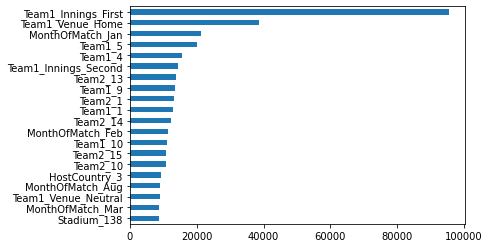

In [ ]:
fi = pd.Series(index=features, data = clf.feature_importances_)
fi.sort_values(ascending=False)[:20][::-1].plot.barh()

In [ ]:
predictions_test_lgb = clf.predict_proba(X_test)

In [ ]:
submission = pd.DataFrame(data=predictions_test_lgb, columns=sub.columns)
submission.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.000559,0.007173,0.423323,0.000164,0.533500,0.006199,0.000666,0.000626,0.000329,0.004511,0.006154,0.000375,0.004418,0.004910,0.005213,0.001880
1,0.000303,0.707658,0.000800,0.000082,0.002464,0.003197,0.000645,0.000263,0.000166,0.002302,0.003240,0.000193,0.003918,0.002537,0.271067,0.001165
2,0.003521,0.004140,0.000839,0.000249,0.002718,0.003533,0.001091,0.000288,0.000194,0.270607,0.702815,0.000332,0.002798,0.002850,0.002972,0.001053
3,0.000446,0.005119,0.001040,0.000125,0.002604,0.004386,0.000489,0.000305,0.000575,0.420326,0.551443,0.000265,0.003477,0.003570,0.003685,0.002144
4,0.000711,0.005565,0.001139,0.000840,0.003670,0.913591,0.000527,0.000371,0.000249,0.003465,0.004768,0.000294,0.003788,0.003820,0.004154,0.053047


#edf

In [ ]:

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from xgboost import XGBClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

In [ ]:
X = train_df.drop(labels=['MatchWinner'], axis=1)
y = train_df['MatchWinner'].values

X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.25, random_state=2**15, stratify=y)

In [ ]:
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)
y_pred = xgb.predict_proba(X_cv)

log_loss(y_cv, y_pred)

0.6443465474689977

In [ ]:
err = []
y_pred_tot = []

fold = StratifiedKFold(n_splits=16, shuffle=True, random_state=101)

for train_index, test_index in fold.split(X, y):
    
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    xgb = XGBClassifier(n_estimators=90,random_state=42)
    xgb.fit(X_train, y_train)
    y_pred = xgb.predict_proba(X_test)
    
    print("Log Loss:", log_loss(y_test, y_pred))

    err.append(log_loss(y_test, y_pred))
    p = xgb.predict_proba(Xtest)
    y_pred_tot.append(p)

Log Loss: 0.6560304456740428
Log Loss: 0.6491959188014839
Log Loss: 0.6557500628861272
Log Loss: 0.7346485184303894
Log Loss: 0.6817730611225792
Log Loss: 0.7064105832273033
Log Loss: 0.6335567490784986
Log Loss: 0.6859896200809888


ValueError: ignored

In [ ]:
np.mean(err, 0)

0.6754193699126767

In [ ]:
y_pred = np.mean(y_pred_tot, 0)

In [ ]:

sub = pd.DataFrame(y_pred)
sub.head(4)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.000595,0.002909,0.540846,0.000437,0.429525,0.003942,0.000599,0.000938,0.000444,0.005051,0.003794,0.000520,0.003201,0.002285,0.003052,0.001864
1,0.000377,0.688066,0.000806,0.000271,0.001944,0.001825,0.000390,0.000465,0.000379,0.001960,0.002072,0.000323,0.001200,0.001458,0.297634,0.000828
2,0.001342,0.002244,0.000968,0.000661,0.002315,0.002888,0.000636,0.000582,0.000361,0.305818,0.673822,0.000424,0.002318,0.001607,0.002324,0.001690
3,0.000941,0.002096,0.000885,0.000323,0.002086,0.002610,0.000473,0.000532,0.000328,0.469602,0.512214,0.000383,0.001981,0.001829,0.002257,0.001459


In [ ]:
sub.to_excel('che.xlsx', index=False)

In [ ]:
from google.colab import files
files.download('che.xlsx')

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
X = train_df.drop(labels=['MatchWinner'], axis=1)
y = train_df['MatchWinner'].values

X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.25, random_state=2**15, stratify=y)

In [ ]:
lgbb = LogisticRegression(C=1.0,random_state=2**15)
lgbb.fit(X_train, y_train)
y_pred = lgbb.predict_proba(X_cv)

log_loss(y_cv, y_pred)

0.6912592018957419

In [ ]:
err = []
y_pred_total = []

fold = StratifiedKFold(n_splits=8, shuffle=True, random_state=101)

for train_index, test_index in fold.split(X, y):
    
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    lgbb = LogisticRegression(penalty='l2', dual=False, tol=0.1, C=1.0, fit_intercept=True, intercept_scaling=1, random_state=2**15, solver='newton-cg', max_iter=1000, multi_class='ovr')
    lgbb.fit(X_train, y_train)
    y_pred = lgbb.predict_proba(X_test)
    
    print("Log Loss:", log_loss(y_test, y_pred))

    err.append(log_loss(y_test, y_pred))
    p = lgbb.predict_proba(Xtest)
    y_pred_total.append(p)

Log Loss: 0.9511038942314467
Log Loss: 1.394300294988533
Log Loss: 1.1157009933082416
Log Loss: 1.0245783934284338
Log Loss: 0.9947676940934813
Log Loss: 1.1198368607284346
Log Loss: 1.439605425575139
Log Loss: 1.3036053968264374


In [ ]:
target='MatchWinner'

In [ ]:
# import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import GradientBoostingClassifier
preds = []

valid_score_list = []
cv = StratifiedKFold(n_splits=8, shuffle=True, random_state=12121212) 
for i, (train_ind, test_ind) in enumerate(cv.split(train, train[target])):
    data_train = train.iloc[train_ind].reset_index(drop=True)
    data_valid = train.iloc[test_ind].reset_index(drop=True)
    
    clf = GradientBoostingClassifier(#n_jobs=-1,
                                     learning_rate=0.2,
                                     n_estimators=10)
                                     #class_weight='balanced')
    X_train = data_train.drop([target], axis=1)
    X_valid = data_valid.drop([target], axis=1)
    X_test = test.copy()

    clf.fit(X_train, data_train[target])
    
    valid_prediction = clf.predict_proba(X_valid)
    valid_score = log_loss(data_valid[target], valid_prediction)
    valid_score_list.append(valid_score)
    print("FOLD:{} Score:{:0.2f}".format(i+1, valid_score))
    
    preds.append(clf.predict_proba(X_test))
    
print("CV score is {}".format(np.mean(valid_score_list)))

FOLD:1 Score:0.81


KeyboardInterrupt: ignored

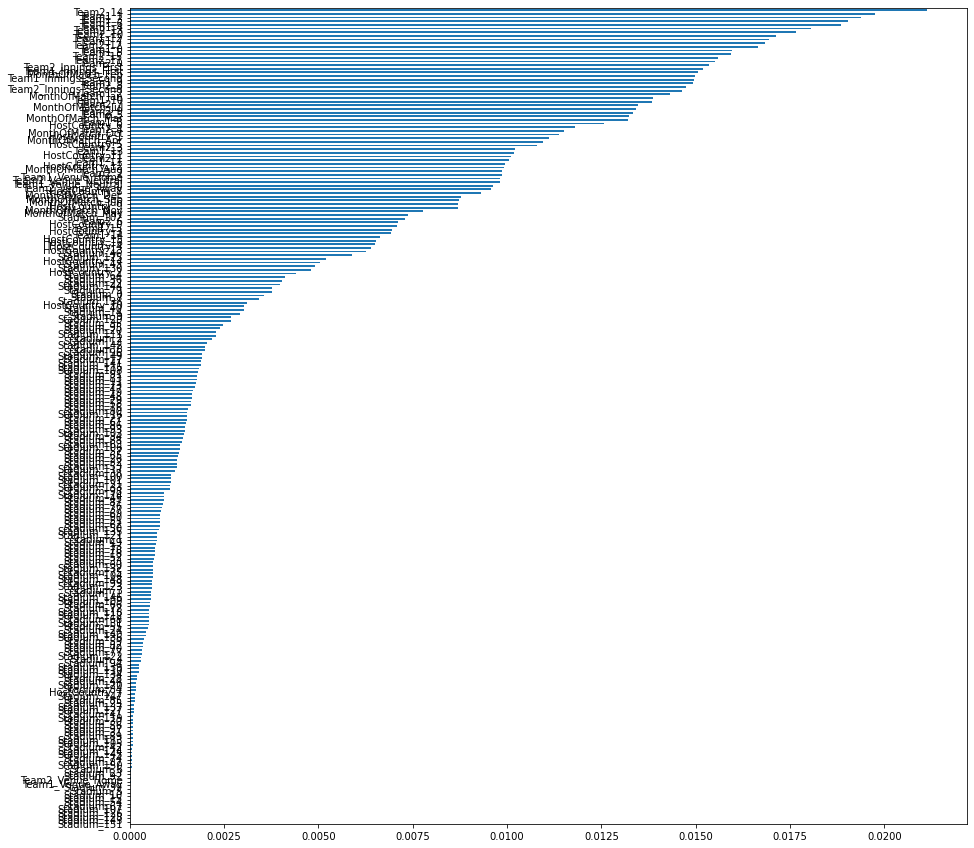

In [ ]:

pd.Series(clf.feature_importances_, index=X_train.columns).sort_values().plot(kind='barh', figsize=(15,15))

In [ ]:
prediction = np.mean(preds, axis=0)

In [ ]:
sub = pd.DataFrame(prediction)
sub.head(4)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.000935,0.025035,0.585309,0.0,0.128664,0.037379,0.000000,0.000502,0.000067,0.057603,0.021359,0.0,0.075341,0.029403,0.033551,0.004853
1,0.000000,0.484666,0.000400,0.0,0.061742,0.005867,0.000000,0.000000,0.000000,0.010888,0.006433,0.0,0.007200,0.000067,0.422671,0.000067
2,0.019083,0.018312,0.000000,0.0,0.029263,0.007538,0.000333,0.000067,0.000000,0.153733,0.706830,0.0,0.018812,0.030504,0.012407,0.003117
3,0.000000,0.009911,0.000000,0.0,0.013128,0.018600,0.000000,0.000000,0.000067,0.374710,0.431509,0.0,0.011953,0.039104,0.092921,0.008097


In [ ]:
sub.to_excel('prd.xlsx', index=False)

In [ ]:
from google.colab import files
files.download('prd.xlsx')

In [ ]:
rff = RandomForestClassifier(random_state=2**15)
rff.fit(X_train, y_train)
y_pred = rff.predict_proba(X_cv)

log_loss(y_cv, y_pred)

1.1072188985858264

In [ ]:
err = []
y_pred_total = []

fold = StratifiedKFold(n_splits=8, shuffle=True, random_state=101)

for train_index, test_index in fold.split(X, y):
    
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    rff = RandomForestClassifier(n_estimators=1000, criterion='gini', max_depth=161, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)
    rff.fit(X_train, y_train)
    y_pred = rff.predict_proba(X_test)
    
    print("Log Loss:", log_loss(y_test, y_pred))

    err.append(log_loss(y_test, y_pred))
    p = rff.predict_proba(Xtest)
    y_pred_total.append(p)

Log Loss: 0.8511887281238544
Log Loss: 1.1083936070548124


KeyboardInterrupt: ignored

In [ ]:
np.mean(err, 0)

0.7179890921860389

In [ ]:
y_pred = np.mean(y_pred_total, 0)

In [ ]:
sub = pd.DataFrame(y_pred)
sub.head(4)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.003139,0.007180,0.489781,0.000892,0.451266,0.004698,0.000767,0.003747,0.001114,0.007533,0.009874,0.000717,0.005998,0.008297,0.002978,0.002019
1,0.001406,0.718357,0.000935,0.000431,0.004689,0.001271,0.000952,0.000858,0.000874,0.001349,0.002568,0.000277,0.001885,0.000987,0.262587,0.000574
2,0.007999,0.002527,0.000617,0.001475,0.006770,0.002807,0.001820,0.000627,0.000971,0.221696,0.736586,0.000965,0.008208,0.001089,0.002639,0.003204
3,0.000931,0.003002,0.000651,0.000359,0.004359,0.002010,0.000596,0.000434,0.000851,0.370163,0.607856,0.000482,0.001408,0.002306,0.002282,0.002308


In [ ]:
sub.to_excel('lr.xlsx', index=False)

In [ ]:
from google.colab import files
files.download('lr.xlsx')